# CS 342 Homework 1 - Neural Network Basics

Welcome to your first homework for CS 342! This problem set covers concepts spanning learning with gradients, pytorch, non-linearities and MLPs. There are three main problems, each with several sub-questions. For coding questions, fill in the missing parts (usually denoted `...`). For theoretical questions, write the answer in the provided markdown block. Please answer all questions in-line, being as brief and precise as possible. You will not need any libraries that aren't already imported here. This code can be run on your local machine.

Please follow <a href="https://pytorch.org">these instructions</a> to install pytorch.

Submission: Upload your jupyter notebook on canvas.

Good luck!

Enter your name and EID in the following block:

Hyunsung Oh (ho3626)

If you worked with anyone on this homework, please list them below:

_(edit this box)_

In [54]:
# Run these two blocks to load important libraries and set things up
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [55]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Problem 1. Approximating $y=\sin(x)$ using a multi-layer perceptron (MLP) (20 pts)

Neural networks that use non-linearities like ReLU are universal function approximators. Let's build a neural network that has a scalar input ($x$), scalar output ($\hat{y}$), and one hidden layer with ReLU nonlinearities.

Mathematically we will define our network like this:
$$ \hat{y}(x) = \sum_{j=1}^n w_j^{out}\cdot\mbox{ReLU}(w_j^{in}\cdot x + b_j), $$
where $n$ is the number of units in the hidden layer, $w^{out}$ is a length-$n$ vector containing "output" weights, $w^{in}$ is a length-$n$ vector containing "input" weights, and $b$ is a length-$n$ vector containing biases.

The first thing we'll do is define a class `ReLUMLP` that describes this network. This class will subclass `nn.Module`, a base class used in pytorch for neural networks (and their components).

This class will need to define three methods:
* `__init__`, which will create the necessary tensors and nonlinearity,
* `forward`, which will compute $\hat{y}$ from $x$ (or, more accurately, a vector of $\hat{y}$ values from a vector of $x$ values), and
* `parameters`, which will tell the optimizer what the trainable parameters of this network are.

HINTS:
* Look at the equation above and _think carefully_ about how many values there should be in $w^{in}$ and $w^{out}$ and $b$.
* You should be using matrix multiplication here, make sure you understand how that works and what sizes the inputs should be. The `*` operator does _not_ perform matrix multiplication. You do not need to (and should not) add any for loops in your solutions.
* Be careful about parameter initialization! Remember what we talked about in class regarding symmetry breaking.

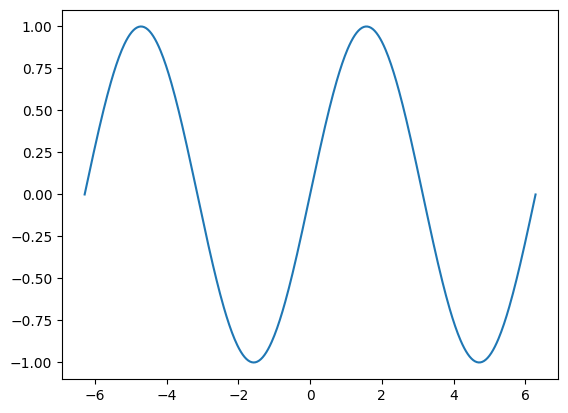

In [56]:
x = np.linspace(-2*np.pi, 2*np.pi, 500)
y = np.sin(x)

plt.plot(x, y)

### Q1.1: Complete the class in the cell below. (5 pts)

In [57]:
class ReLUMLP(nn.Module):
    def __init__(self, n):
        """Initialize ReLUMLP with `n` units in its hidden layer.
        """
        super().__init__()
        self.nonlin = nn.ReLU() # oddly, we need to store this as an object!

        # create tensors for each set of parameters. remember to use requires_grad.
        # you also need to provide reasonable initial values!
        self.wt_in = torch.randn(n, 1, requires_grad=True)
        self.bias_in = torch.randn(n, requires_grad=True)
        self.wt_out = torch.randn(1, n, requires_grad=True)

    def forward(self, x):
        """Given a vector `x`, compute `y-hat` for each entry.
        This can be accomplished in several ways, but pytorch is picky about how
        you do it!
        """
        hidden = self.nonlin(torch.matmul(x, self.wt_in.T) + self.bias_in)
        y_hat = torch.matmul(hidden, self.wt_out.T)

        return y_hat

    def parameters(self):
        """Tells the optimizer which parameters to optimize. Annoying that we
        have to be explicit about this!
        """
        return [self.wt_in, self.bias_in, self.wt_out]

### Q 1.2: Complete the training function (2 pts)
Next, we need to define a function that will train our network. We provide most of this function here, but you will need to fill in the parts that compute model predictions (`y_hat`) and loss (`loss`).

In [58]:
def train_MLP(train_x, train_y, model, nepoch=1000):
    """Train an MLP `model` with training inputs `train_x` and outputs `train_y`
    for `nepoch` steps.
    """
    # Create the optimizer -- here we will use Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

    # Create the loss object
    loss_function = torch.nn.MSELoss()

    # Make sure the inputs are torch tensors
    train_x_0 = torch.tensor(train_x, dtype=torch.float32)
    train_y_0 = torch.tensor(train_y, dtype=torch.float32)

    # We will store the losses to track our model's behavior
    losses = []

    for epoch in range(nepoch):
        # pytorch usually accumulates gradients over all backward passes.
        # Since we want to start afresh after every gradient update,
        # we explicitly reset gradients to 0.
        optimizer.zero_grad()

        # compute the model predictions using the forward method you defined earlier
        y_hat = model(train_x_0)

        # compute the loss using the predictions, true values, and loss function
        loss = loss_function(y_hat, train_y_0)

        # compute gradients!
        loss.backward()

        # update the parameters using the optimizer's step method
        optimizer.step()

        # store & (maybe) display losses
        losses.append(loss.item())
        if not epoch%100:
            print("Loss @ {epoch}: ".format(epoch=epoch), losses[-1])

    return losses


### Q 1.3: Run the model and visualize the results! (2 pts)
_(this is where the fun begins)_

Fill in the code to create the model object, train the model, and plot the results. If this doesn't work well (i.e. final loss is greater than 0.1 or the function looks very weird) then you probably have a bug. If you have set everything up correctly, the default `nepoch` and `lr` should work correctly.

Loss @ 0:  375.8505554199219
Loss @ 100:  0.129582941532135
Loss @ 200:  0.10933174192905426
Loss @ 300:  0.09849442541599274
Loss @ 400:  0.08487194031476974
Loss @ 500:  0.0714866891503334
Loss @ 600:  0.05898773670196533
Loss @ 700:  0.048111215233802795
Loss @ 800:  0.03915753588080406
Loss @ 900:  0.03198787197470665


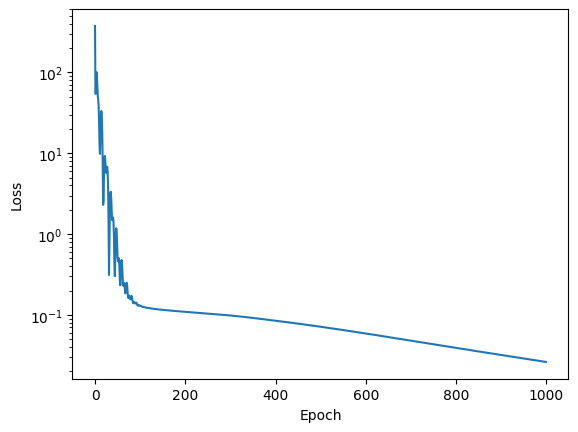

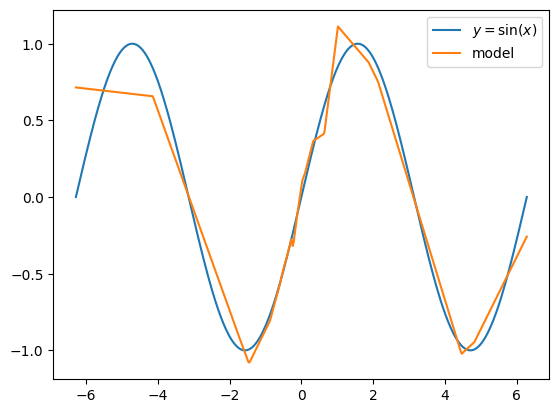

In [59]:
# first, create the model
# try with n=40 units in the hidden layer -- this should work well!
model = ReLUMLP(n=40)

# then train it!
losses = train_MLP(x[:, None], y[:, None], model)

# plot the losses (semilogy is your friend)
plt.figure()
plt.semilogy(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# and plot the learned function
plt.figure()
predictions = model(torch.tensor(x[:, None], dtype=torch.float32)).detach().numpy()
plt.plot(x, y, label=r"$y=\sin(x)$")
plt.plot(x, predictions, label="model")
plt.legend()

### Q 1.4: Experimenting with learning rate (`lr`) and number of training epochs (`nepoch`) (3 pts)
Using the default settings should work reasonably well, but we can also adjust the learning rate and number of steps taken during learning.

Copy the model fitting & visualization code into the cell below, and then try adjusting the `lr` and `nepoch` parameters that can be passed to `train_MLP`.

In [60]:
model = ReLUMLP(n=40)
losses = train_MLP(x[:, None], y[:, None], model)

Loss @ 0:  154.13137817382812
Loss @ 100:  0.10426178574562073
Loss @ 200:  0.07353854179382324
Loss @ 300:  0.049733541905879974
Loss @ 400:  0.029222099110484123
Loss @ 500:  0.014793315902352333
Loss @ 600:  0.008115770295262337
Loss @ 700:  0.0047974977642297745
Loss @ 800:  0.003012961708009243
Loss @ 900:  0.0020030844025313854


(In the spaces provided, answer the following questions:)

* If you set the learning rate to be too large, what happens?

If the learning rate is too large, the model cannot learn well because it can just pass the point where the gradient=0.

* If you set the learning rate to be too small, what happens?

If the learning rate is too small, the model cannot learn well because the gradient changes too little at each step so it cannot easily find the point where gradient=0.

* Do the learning rate and number of epochs interact? i.e. if you change one, does it affect the best value for the other

The learning rate and the number of epochs interact because if the learning rate is large, we can find the gradient=0 point with low epoch and if the learning rate is small, we will need more epoches in order to find the point that gradient=0.

### Q 1.5: Simpler models using `nn.Sequential` (3 pts)
The function you wrote out above should work, but writing things so explicitly in pytorch is pretty annoying. You have to figure out how to handle multiple inputs, and also list out all the parameters. Ugh! Fortunately, there's a nicer interface that we can use!

To represent a _linear transformation_ of some input, you can use the `nn.Linear` object. Our function here should consist of three steps:
1. a linear transformation from 1 dimension ($x$) to $n$ dimensions, including a bias term,
2. a ReLU nonlinearity, and
3. a linear transformation from $n$ dimensions to 1 dimension ($y$) which does not include a bias term.

These steps can be rolled into an [`nn.Sequential` object](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). See those docs for an example, then write out the sequential version of your ReLU MLP in the following cell.

In [61]:
class BetterReLUMLP(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1,n),
            nn.ReLU(),
            nn.Linear(n, 1, bias=False)
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(1)
        # this is still slightly tricky. make sure that your output has only one dimension
        return self.layers(x).squeeze(1)

### Q 1.6: Train your `BetterReLUMLP` (2 pts)
Now instantiate and train your new model! Note that `nn.Linear` expects a certain datatype, and your data will need to be in a specific (2D) shape for the training to work. You can use the numpy array method `astype` to convert your data to `np.float32`.

Loss @ 0:  0.4307573735713959
Loss @ 100:  0.09813079982995987
Loss @ 200:  0.06961993873119354
Loss @ 300:  0.06387683004140854
Loss @ 400:  0.05274428054690361
Loss @ 500:  0.04177508130669594
Loss @ 600:  0.029983868822455406
Loss @ 700:  0.025839339941740036
Loss @ 800:  0.027379028499126434
Loss @ 900:  0.1404537707567215


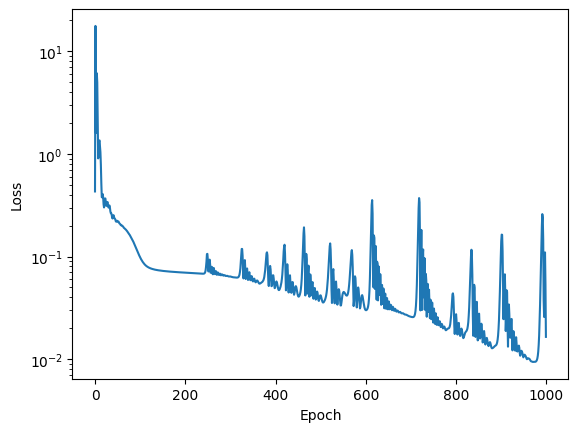

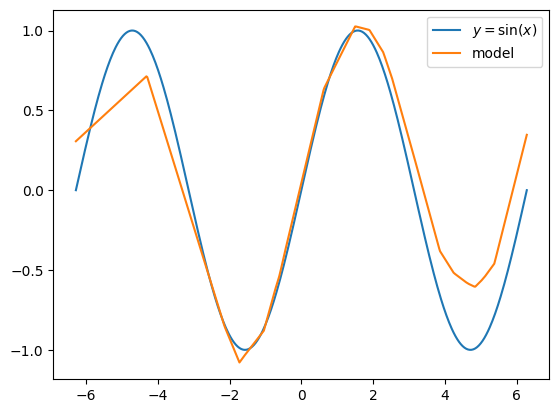

In [62]:
better_model = BetterReLUMLP(n=40)

train_x_ = x.astype(np.float32)
train_y_ = y.astype(np.float32)

losses = train_MLP(train_x_, train_y_, better_model)

# Plot losses (semilogy!)
plt.figure()
plt.semilogy(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot model predictions
plt.figure()
predictions = better_model(torch.tensor(train_x_, dtype=torch.float32))
plt.plot(train_x_, train_y_, label=r"$y=\sin(x)$")
plt.plot(train_x_, predictions.detach().numpy(), label="model")
plt.legend()
plt.show()

### Q 1.7: Switching from ReLU to a different nonlinearity (3 pts)
Now that you have things set up using `nn.Sequential`, it's trivial to try different network architectures, or swap out one nonlinearity for another.

For this problem, write a new class, `SigmoidMLP`, that uses a Sigmoid nonlinearity. Then try it out with a few different hidden layer sizes and answer the question in the cell below.

In [63]:
class SigmoidMLP(nn.Module):
    def __init__(self, n):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(1, n),
            nn.Sigmoid(),
            nn.Linear(n, 1)
        )

    def forward(self, x):
        return self.layers(x)

<ipython-input-58-578ce3b417d2>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x_0 = torch.tensor(train_x, dtype=torch.float32)
<ipython-input-58-578ce3b417d2>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y_0 = torch.tensor(train_y, dtype=torch.float32)


Loss @ 0:  0.4981984496116638
Loss @ 100:  0.08154051750898361
Loss @ 200:  0.04608086496591568
Loss @ 300:  0.02967705950140953
Loss @ 400:  0.021123526617884636
Loss @ 500:  0.017719248309731483
Loss @ 600:  0.014652512967586517
Loss @ 700:  0.008658118546009064
Loss @ 800:  0.0029017331544309855
Loss @ 900:  0.0012045458424836397


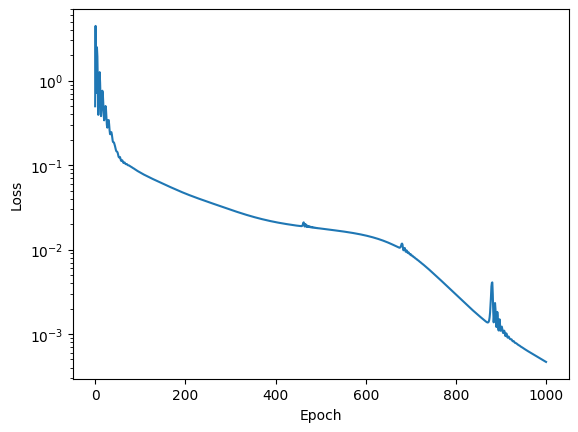

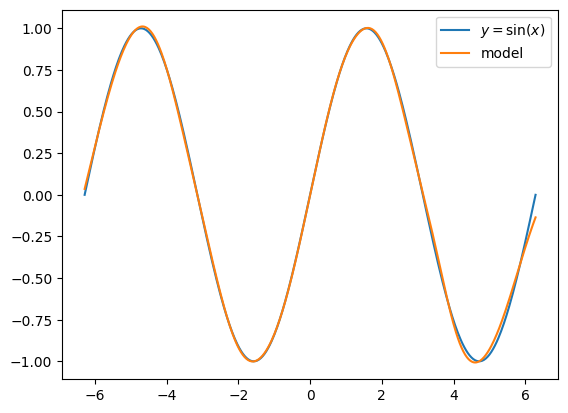

In [64]:
sigmoid_model = SigmoidMLP(n=40)

train_x_ = torch.tensor(x.astype(np.float32), dtype=torch.float32).unsqueeze(1)
train_y_ = torch.tensor(y.astype(np.float32), dtype=torch.float32).unsqueeze(1)

losses = train_MLP(train_x_, train_y_, sigmoid_model)

# Plot losses (semilogy!)
plt.figure()
plt.semilogy(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot model predictions
plt.figure()
predictions = sigmoid_model(train_x_)
plt.plot(train_x_, train_y_, label=r"$y=\sin(x)$")
plt.plot(train_x_, predictions.detach().numpy(), label="model")
plt.legend()
plt.show()

In the spaces below, answer the following questions:

* How are the results of using a sigmoid different than using a ReLU?

When using ReLU, there are many losses when the epoches are small, but when using sigmoid, there aren't many losses regardless of the epoches.

* Which seems better suited to this problem? Why?

Using sigmoid is better suited to this problem because it shows the sine graph more elaborately.

## Problem 2. Examining gradients and non-linearities in MLPs (19 Points)

In this problem, we will consider a simple MLP of the form: $f(x) = w_{out}\cdot\sigma(w_{in}\cdot x)$ where $x, w_{out}, w_{in}$ are all scalars, and we assume biases to be 0.

In [65]:
# We will use a single training example to train the model.
x, y = 1., -1.

### Q 2.1: Implement the 1x1 MLP in pytorch below using <a href="https://pytorch.org/docs/stable/generated/torch.nn.Linear.html">torch.nn.Linear</a> (3 pts)

In [66]:
class TinySigmoidMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.io = nn.Linear(1, 1)

    def forward(self, x):
        x = self.io(x)
        x = torch.sigmoid(x)
        return x

sigmoid_model = TinySigmoidMLP()

### Q 2.2: Set the training `loss_function` to the mean squared error loss function in pytorch (1 pt)

In [67]:
loss_function = torch.nn.MSELoss()

### Q 2.3: For this MLP, what is the analytical formula for the gradients? here, `L` refers to the MSE loss you initialized above (2 pts)
Pytorch automatically computes gradients through a computational graph, so you needn't actually code the gradient computation. But let's figure out what it is! Please write out the expressions for the gradients at the most granular level you can. For the derivative of the sigmoid, please just use $\sigma'(\cdot)$.

A. $\frac{\partial L}{\partial w_{out}} = 0$

B. $\frac{\partial L}{\partial w_{in}} =(y_{hat} - y) ⋅ σ′(w_{in}⋅x)x$

### Q 2.4: Finally, put all this together to write a training loop. Here, `w_in_init` and `w_out_init` refer to the initial value of the weights we will set (3 pts)

In [68]:
def train_TinyMLP(train_x, train_y, w_in_init, w_out_init, model, optimizer, nepoch):
    train_x_0 = torch.tensor(train_x, dtype=torch.float32)
    train_y_0 = torch.tensor(train_y, dtype=torch.float32)
    # Initialize the weights of the network manually.
    # the no_grad() below ensures that autograd doesn't know about this weight change!
    with torch.no_grad():
        # Set initial weights `w_in_init` and `w_out_init`.
        model.io.weight[0][0] = w_in_init
        model.io.weight[0][0] = w_out_init

    # We will store the predictions, losses etc. to track our model behavior.
    predictions = []
    losses = []
    in_gradients, out_gradients = [], []

    for epoch in range(nepoch):
        # PyTorch usually accumulates gradients over all backward passes.
        # Since we want to start afresh after every gradient update,
        # we explicitly reset gradients to 0.
        optimizer.zero_grad()
        y_hat = model(train_x_0)
        predictions.append(y_hat.item())
        loss = torch.nn.MSELoss()(y_hat, train_y_0)
        losses.append(loss.item())
        loss.backward()
        # Append gradients of each weight parameter.
        in_gradients.append(model.io.weight.grad[0][0].item())
        out_gradients.append(model.io.weight.grad[0][0].item())
        optimizer.step()
    return predictions, losses, in_gradients, out_gradients

In [69]:
# This is a simpler matplotlib helper function to visualize your model params.
def visualize(y, predictions, losses, in_gradients, out_gradients, nepoch):
    fig, axs = plt.subplots(4, 1, figsize=(10, 7), sharex=True)
    for ax, vals, title in zip(
            axs,
            [predictions, losses, in_gradients, out_gradients],
            ['$\hat{y}$', 'Loss', '$w_{in}$ gradient', '$w_{out}$ gradient']):
        ax.plot(range(len(vals)), vals, 'o-', lw=2, label=title)
        ax.set_ylabel(title, fontsize=14)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if title == '$\hat{y}$':
            ax.hlines(y, 0, nepoch, ls=':', color='k', lw=3, label='$y$')
            ax.legend(fontsize=14)
    return

### Q 2.5: Given the weight initializations below, run the model training, then answer the questions below (2 pts)


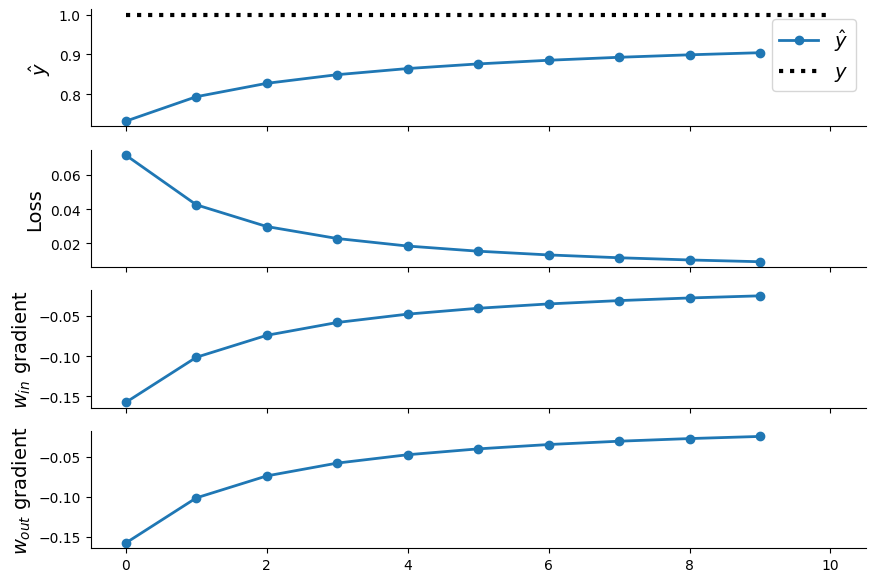

In [70]:
# For now, use the stochastic gradient descent optimizer.
optimizer = torch.optim.SGD(sigmoid_model.parameters(), lr=1)
# Number of gradient updates we want to do over the training set.
# You might need to play with this if the learning is too fast or slow.

x = [[1.5]]
y = [[1]]
nepoch = 10

# Now, let's try these weight initializations
w_in_init, w_out_init = 1, 1
predictions, losses, in_gradients, out_gradients = train_TinyMLP(
    x, y, w_in_init, w_out_init, sigmoid_model, optimizer, nepoch)

visualize(y, predictions, losses, in_gradients, out_gradients, nepoch)

- Does the loss _converge_? (i.e., does it stop changing) What is the loss
value at the end of training? Answer in the box below.

The loss does not converge because the loss keep changes when I change the size of epoches.

- If the model doesn't converge to the correct answer, briefly explain what could be wrong and how you would fix it.

HINT: The answers lie in the plots we are visualizing and Q 2.3. Pay close attention to how the value of each parameter changes over the course of training.

The model could be wrong when the size of the Learning Rate is too big or Vanishing Gradient happens. In order to fix this, we can lower the Learning Rate or change the activation function.

### Q 2.6: Now train a new model using the given weight initialization, then answer the questions below (2 pts)

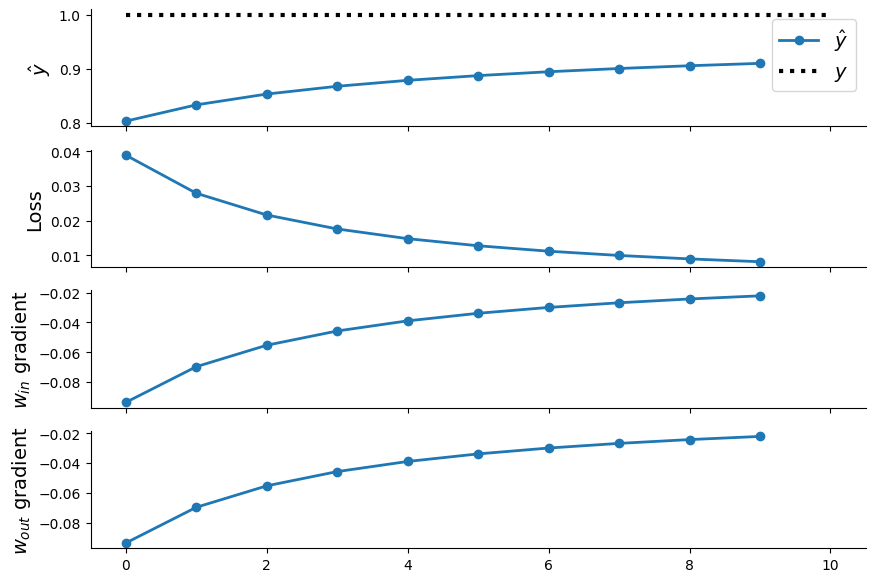

In [71]:
# For now, use the stochastic gradient descent optimizer.
optimizer = torch.optim.SGD(sigmoid_model.parameters(), lr=1)
# Number of gradient updates we want to do over the training set.
# You might need to play with this if the learning is too fast or slow.
nepoch = 10

w_in_init, w_out_init = 20, 1
predictions, losses, in_gradients, out_gradients = train_TinyMLP(
    x, y, w_in_init, w_out_init, sigmoid_model, optimizer, nepoch)

visualize(y, predictions, losses, in_gradients, out_gradients, nepoch)

- Does the loss _converge_? What is the loss value at the end of training?

The loss does not converge in this case. The loss value at the end of training seems to be 0.004.

- If the model doesn't converge to the correct answer, briefly explain what could be wrong and how you would fix it.

HINT: The answers lie in the plots we are visualizing and Q2.3. Pay close attention to how the value of each parameter changes over the course of training.

In this case, the initial value of w_in_init was set too large. It will make the sigmoid function saturate. We can make w_in_init smaller in order to fix it.

### Q 2.7: Implement the same MLP architecture but with ReLU nonlinearity instead of sigmoid (2 pts)

In [72]:
class TinyReLUMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.fc_in = nn.Linear(1, 1, bias=False)
        self.fc_out = nn.Linear(1, 1, bias=False)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.relu(x)
        x= self.fc_out(x)
        return x

relu_model = TinyReLUMLP()

### Q 2.8: Train this model with the given weight initializations, then answer the question below (2 pts)

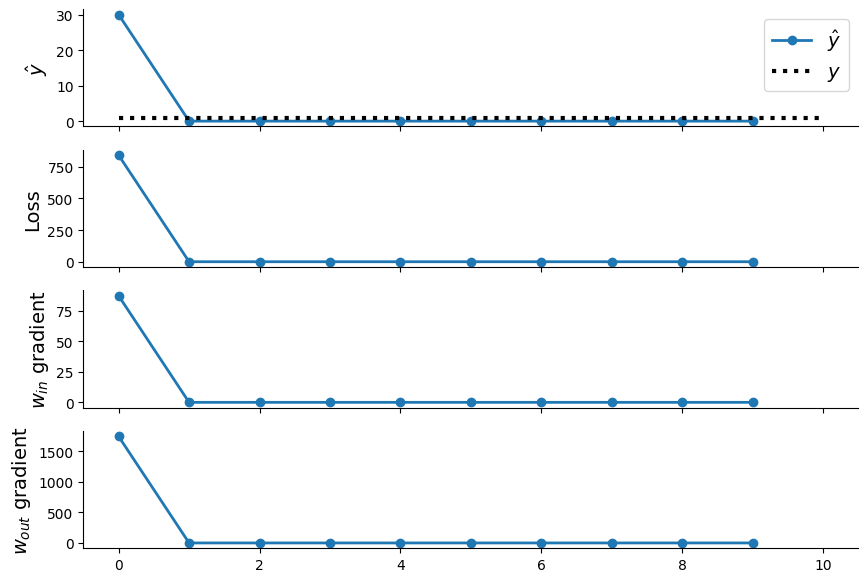

In [73]:
def train_TinyMLP(train_x, train_y, w_in_init, w_out_init, model, optimizer, nepoch):
    train_x_0 = torch.tensor(train_x, dtype=torch.float32)
    train_y_0 = torch.tensor(train_y, dtype=torch.float32)
    # Initialize the weights of the network manually.
    # the no_grad() below ensures that autograd doesn't know about this weight change!
    with torch.no_grad():
        # Set initial weights `w_in_init` and `w_out_init`.
        model.fc_in.weight[0][0] = w_in_init
        model.fc_out.weight[0][0] = w_out_init

    # We will store the predictions, losses etc. to track our model behavior.
    predictions = []
    losses = []
    in_gradients, out_gradients = [], []

    for epoch in range(nepoch):
        # PyTorch usually accumulates gradients over all backward passes.
        # Since we want to start afresh after every gradient update,
        # we explicitly reset gradients to 0.
        optimizer.zero_grad()
        y_hat = model(train_x_0)
        predictions.append(y_hat.item())
        loss = torch.nn.MSELoss()(y_hat, train_y_0)
        losses.append(loss.item())
        loss.backward()
        # Append gradients of each weight parameter.
        in_gradients.append(model.fc_in.weight.grad[0][0].item())
        out_gradients.append(model.fc_out.weight.grad[0][0].item())
        optimizer.step()
    return predictions, losses, in_gradients, out_gradients

    # This is a simpler matplotlib helper function to visualize your model params.
def visualize(y, predictions, losses, in_gradients, out_gradients, nepoch):
    fig, axs = plt.subplots(4, 1, figsize=(10, 7), sharex=True)
    for ax, vals, title in zip(
            axs,
            [predictions, losses, in_gradients, out_gradients],
            ['$\hat{y}$', 'Loss', '$w_{in}$ gradient', '$w_{out}$ gradient']):
        ax.plot(range(len(vals)), vals, 'o-', lw=2, label=title)
        ax.set_ylabel(title, fontsize=14)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if title == '$\hat{y}$':
            ax.hlines(y, 0, nepoch, ls=':', color='k', lw=3, label='$y$')
            ax.legend(fontsize=14)
    return

optimizer = torch.optim.SGD(relu_model.parameters(), lr=1)
# Number of gradient updates we want to do over the training set.
# You might need to play with this if the learning is too fast or slow.

x = [[1.5]]
y = [[1]]
nepoch = 10

w_in_init, w_out_init = 20, 1
predictions, losses, in_gradients, out_gradients = train_TinyMLP(
    x, y, w_in_init, w_out_init, relu_model, optimizer, nepoch)

visualize(y, predictions, losses, in_gradients, out_gradients, nepoch)

You will find that it doesn't converge to zero loss (note the y-axis on the loss plot). Why is that? Is the ReLU MLP plagued with the same issues as the sigmoid MLP? How can you fix it (without changing the weight initialization)? Please answer below.

HINT: Think about what $\frac{\partial L}{\partial w_{out}}$ and $\frac{\partial L}{\partial w_{in}}$ would be for the ReLU MLP. The answer is in the size of updates we perform.

The reason for why it doesn't converge to zero loss is because ReLU outputs 0 when the input is 0 or negative, and it outputs the value itself when the value is positive. It is different with sigmoid because it does not make the output zero for every input less or same as 0. We can fix it by making Learning Rate lower which makes gradient not to change in big range.

### Q 2.9: Fix how you fit the above ReLU model and run the `visualize` function (2 pts)

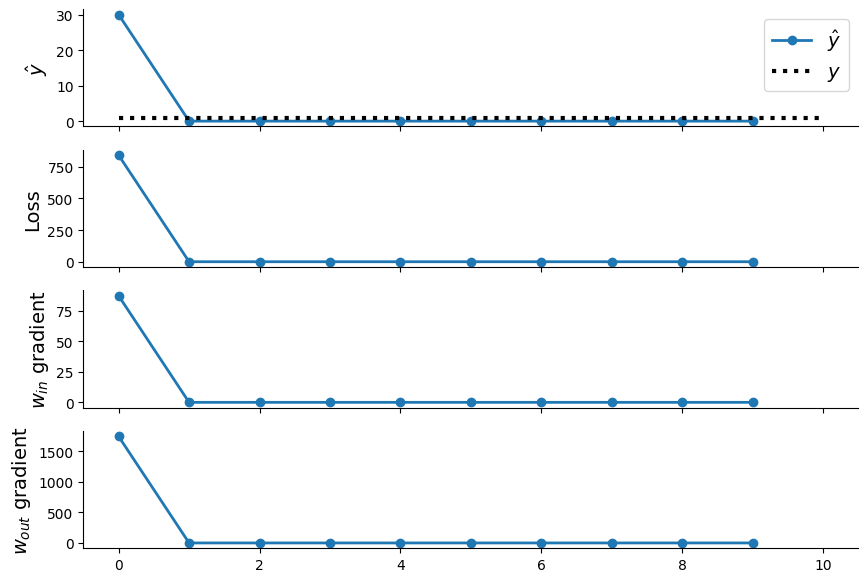

In [74]:
new_relu_model = TinyReLUMLP()

optimizer = torch.optim.SGD(new_relu_model.parameters(), lr=1)
# Number of gradient updates we want to do over the training set.
# You might need to play with this if the learning is too fast or slow.
nepoch = 10

w_in_init, w_out_init = 20, 1
predictions, losses, in_gradients, out_gradients = train_TinyMLP(
    x, y, w_in_init, w_out_init, new_relu_model, optimizer, nepoch)

visualize(y, predictions, losses, in_gradients, out_gradients, nepoch)

## Problem 3. Training MLPs on the Fashion MNIST dataset (22 Points)

In this problem, we will build MLPs on a freely available vision dataset, <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST</a>. This data has been increasingly gaining popularity as the "hello world!" of the ML community. It is simple enough to test new ideas on, and complex enough that our current models still have room for improvement. While you will find several blog-posts on MLPs for this dataset, we encourage you to work through this on your own- this is designed to familiarize you with pytorch and basic neural networks, for your class project and beyond.

Fashion MNIST consists of many 28x28 grayscale images belonging to 10 different classes of clothing. The task is to train a classifier that can predict the clothing class from the image.

In [75]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

#### Let's load the data in pytorch!

All PyTorch datasets have a `tranform` argument to apply common transforms to the input data like normalizing, converting to a tensor etc.. Similarly, the `target_transform` argument can be applied to the output data (we will not use it here).

Read about torch datasets and dataloaders <a href="https://pytorch.org/vision/stable/datasets.html">here</a>!

In [76]:
from torchvision import datasets, transforms

save_dir = 'fashionMNIST_data'

transform = transforms.ToTensor() # Convert the image into a torch tensor.

train_set = datasets.FashionMNIST(save_dir, download=True, train=True, transform=transform)
test_set = datasets.FashionMNIST(save_dir, download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: fashionMNIST_data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: fashionMNIST_data
    Split: Test
    StandardTransform
Transform: ToTensor()


Each of these sets comprises of the image `data` and the clasification `targets`. The `targets` take a numerical value from 1-10 indicating which clothing class each image belongs to.

### Q 3.1 (2 pts)
- Print a list of the classes in the train and test datasets.
- Visualize the first image in the training set.
- Print its classification label.

HINT:
`plt.imshow(image_array, cmap = 'Greys_r')` where `image_array` is a 28x28 array of the pixel values in the image.

Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


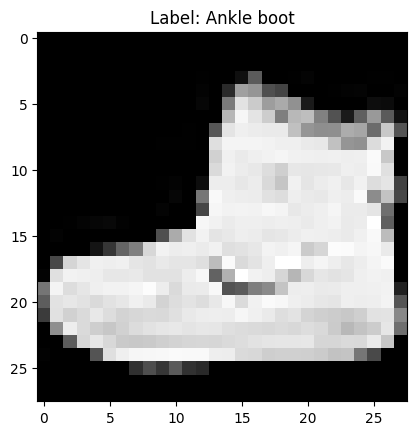

Label: Ankle boot


In [77]:
# print classes
classes = train_set.classes
print("Classes:", classes)
# print label
first_image, first_label = train_set[0]

plt.imshow(first_image.squeeze(), cmap='Greys_r')
plt.title(f"Label: {classes[first_label]}")
plt.show()

print(f"Label: {classes[first_label]}")

Since the original data does not have a validation set, let's create one by splitting the training set.

In [78]:
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 60000
ntrain = int(0.9*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

### Q 3.2: Initialize the train, val and test dataloaders with the given `batch_size` (1 pt)

In [79]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, sampler=train_sampler, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(train_set, sampler=val_sampler, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

Each loader iterates over the data, yielding `batch_size` images and output targets per iteration.

In [80]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


### Q 3.3: Initialize an MLP with 3 fully-connected layers. You can add any non-linearity of your choice to the first two layers, and choose the layer widths as well (5 pts)

#### Define MLP

We have provided the skeleton class definition below. Complete it by specifying the layer objects in your MLP. Keep in mind that the input `x` is of shape (`batch_size`, 1, 28, 28). To feed this into the MLP, you will have to flatten it to shape (`batch_size`, 1x28x28). Additionally, the output should be of shape (`batch_size`, 10) as we have 10 classes.

You may find PyTorch functions like `reshape`, `view`, `flatten` etc. useful here.

In [81]:
class fashionMLP(nn.Module):
    def __init__(self):
        super(fashionMLP, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 512)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)

        x = self.fc1(x)
        x = self.relu1(x)

        x = self.fc2(x)
        x = self.relu2(x)

        x = self.fc3(x)

        return x

Tip: An easy way to check if you got the dimensions right is to test your model on a single batch. Iteratively add each layer transformation to the input, and ensure the shape is right at each stage.

In [82]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break
model = fashionMLP()
outputs = model(images)
print(outputs.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 10])


#### Loss and optimizer definitions
### Q 3.4: Define `criterion` to be the cross entropy loss function and use an optimizer of your choice (1 pt)

In [83]:
model = fashionMLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Q 3.5 (2 pts)
Answer the following questions below.

- For classification problems, why is the softmax activation used on the final MLP output?

Softmax is used on the final MLP output for classification problems because the output turns into probabilities and the sum of them is 1 so it seems to be like a probility.

- Do you need to apply softmax here?

No, because CrossEntropyLoss applies the log softmax manually so you do not have to apply softmax here.

#### Model training and evaluation
### Q 3.6: Complete the training, validation and testing loops (3 pts)

In [84]:
from tqdm.notebook import tqdm

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=100):
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return

def test_network(model, test_loader, mode):
    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1) # get predicted class label for each test example.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

### Q 3.7: Understanding losses (2 pts)

What could the following scenarios suggest?
- Validation loss is _increasing_ continuously, while training loss continues to improve.
- Training loss  is _increasing_ continuously.

Answer in the box below.

Validation loss increasing can mean overfitting and training loss increasing means that Learning Rate is too big or initializing model is wrong.

### Q 3.8: Train the network and report the final test accuracy of your model (1 pt)
Use the functions `train_network` and `test_network` defined above. You'll need to get performance >75%, and you should be able to get to about 85%.

In [50]:
train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=20)

test_network(model, test_loader, mode="Test")


  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 0.33512
   Val loss: 0.35461

EPOCH 1
 Train loss: 0.33082
   Val loss: 0.35186

EPOCH 2
 Train loss: 0.32606
   Val loss: 0.35477

EPOCH 3
 Train loss: 0.32300
   Val loss: 0.36211

EPOCH 4
 Train loss: 0.31897
   Val loss: 0.35246

EPOCH 5
 Train loss: 0.31496
   Val loss: 0.37082

EPOCH 6
 Train loss: 0.31146
   Val loss: 0.36142

EPOCH 7
 Train loss: 0.30823
   Val loss: 0.34092

EPOCH 8
 Train loss: 0.30492
   Val loss: 0.33853

EPOCH 9
 Train loss: 0.30215
   Val loss: 0.33657

EPOCH 10
 Train loss: 0.29787
   Val loss: 0.33319

EPOCH 11
 Train loss: 0.29536
   Val loss: 0.33713

EPOCH 12
 Train loss: 0.29186
   Val loss: 0.33532

EPOCH 13
 Train loss: 0.28901
   Val loss: 0.36064

EPOCH 14
 Train loss: 0.28530
   Val loss: 0.33274

EPOCH 15
 Train loss: 0.28300
   Val loss: 0.32514

EPOCH 16
 Train loss: 0.28022
   Val loss: 0.34041

EPOCH 17
 Train loss: 0.27705
   Val loss: 0.33109

EPOCH 18
 Train loss: 0.27371
   Val loss: 0.32736

EPOCH 19
 Train loss: 

(87.41, array([9, 2, 1, ..., 8, 1, 5]), array([9, 2, 1, ..., 8, 1, 5]))

### Q 3.9: Which class did the model get wrong the most? Which class did it get right the most? (2 pts)

Hint: Compare the `true` and `pred` labels.

In [ ]:
...

Sorry, I did not have enough time from here.

### Q 3.10: Add any regularization method of your choice (or more than one!), and report the final test accuracy (3 pts)

You'll need to get better accuracy than you did in 3.8.

In [ ]:
class regularized_fashionMLP(nn.Module):
    ...

In [ ]:
# Instantiate the model, criterion, and optimizer
...

# Train the model
...

regmodel.eval() # disables some regularization methods for model testing

# Report test accuracy
...